In [2]:
## NOTE: use py36 virtual environment to run this! -source activate py36
# but use Python 3 kernel! NOT the python 3.6 

# check if right version is being used
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/Users/terlau/miniconda3/envs/py36/bin/python3.6
3.6.13 |Anaconda, Inc.| (default, Feb 23 2021, 12:58:59) 
[GCC Clang 10.0.0 ]
sys.version_info(major=3, minor=6, micro=13, releaselevel='final', serial=0)


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kabuki
import platform
from kabuki.analyze import gelman_rubin
import scipy.io as sio

%matplotlib inline
import hddm
print(hddm.__version__)

import warnings
warnings.filterwarnings('ignore')

0.9.1


In [5]:
# Load data from csv file into a NumPy structured array
def load_hddm_csv(path):
    data = hddm.load_csv(path)
    return data

In [14]:
em1_hddm_study = load_hddm_csv('/Users/terlau/LNDG/EyeMem/EyeMem_1/HDDM/EyeMem_hddm_study.csv')
em1_hddm_test = load_hddm_csv('/Users/terlau/LNDG/EyeMem/EyeMem_1/HDDM/EyeMem_hddm_test.csv')
em2_hddm_study = load_hddm_csv('/Users/terlau/LNDG/EyeMem/EyeMem_2/behavior/plotting/EyeMem_hddm_study.csv')
em2_hddm_test = load_hddm_csv('/Users/terlau/LNDG/EyeMem/EyeMem_2/behavior/plotting/EyeMem_hddm_test.csv')

In [15]:
em2_hddm_test

,subj_idx,category,stim,response,accuracy,rt,age
0,11009,1,0,1.0,1,0.969,0
1,11009,1,0,1.0,1,1.609,0
2,11009,1,1,2.0,1,1.022,0
3,11009,1,1,2.0,1,1.166,0
4,11009,1,0,1.0,1,0.877,0
...,...,...,...,...,...,...,...
14763,99,1,1,1.0,0,1.210,1
14764,99,1,0,2.0,0,0.946,1
14765,99,1,0,2.0,0,1.297,1
14766,99,1,0,2.0,0,1.122,1


### Prepare data for HDDM StimCoding
Fitting the DDM to RT distributions for the two choice categories, conditioned on the stimulus category for each trial - this is referred to as ‘stimulus coding’. This fitting method deviates from a widely used expression of the model, where RT distributions for correct and incorrect choices are fit (also called ‘accuracy coding’). Only the stimulus coding can fit decision biases towards one choice over the other.

In stimulus coding 1’s and 0’s correspond to the choice (e.g. categorization of the stimulus). HDDM interprets 0 and 1 responses as lower and upper boundary responses, respectively, so in principle either of these schemes (acc or stim coding) is valid.

This StimCoding model expects data to have a column named stim with two distinct identifiers. For identifier 1, drift-rate v will be used while for identifier 0, -v will be used. So ultimately you only estimate one drift-rate. Alternatively you can use bias z and 1-z if you set split_param='z'. See the HDDMStimCoding help doc for more information.


In [17]:
def prepare_data(df, study):
    
    appended_data = []
    # create a lst with unique sub ids
    SubjectList = np.unique(df['subj_idx'])
    df.rename(columns={'response':'key'}, inplace=True)

    for sub in SubjectList:

        sub_df = df[df['subj_idx'] == sub]
        # correct & stim was present, hit --> finding response key corresponding to "old"
        resp = np.unique(sub_df["key"][(sub_df["stim"] == 1) & (sub_df["accuracy"] == 1)])

        # 1 (old) and 0 (new) where response key was indicating presence of stim, so subject said "yes I've seen this", 1 i.e. old, and 0 (new) otherwise
        sub_df['response']=np.where(sub_df["key"] == resp[0],1,0)
    
        # store DataFrame in list
        appended_data.append(sub_df)


    data = pd.concat(appended_data)
    plot_RT_dist(data, study)
    return data

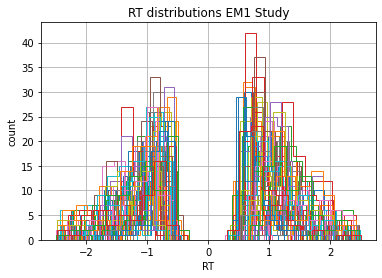

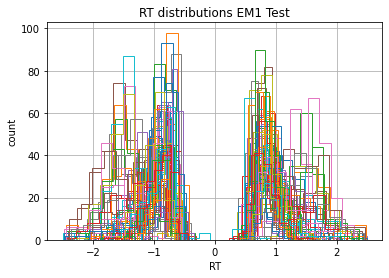

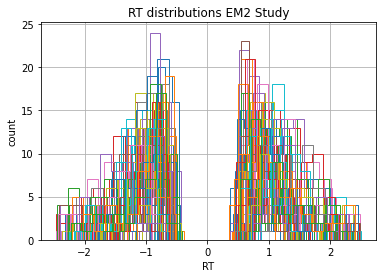

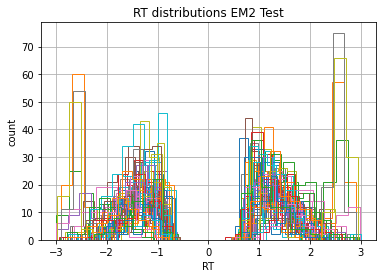

In [21]:
em1_hddm_study_prep = prepare_data(em1_hddm_study, ' EM1 Study')
em1_hddm_test_prep = prepare_data(em1_hddm_test, ' EM1 Test')
em2_hddm_study_prep = prepare_data(em2_hddm_study, ' EM2 Study')
em2_hddm_test_prep = prepare_data(em2_hddm_test, ' EM2 Test')

In [33]:
#convert stim column from int to bool - why??
#final_data['stim'] = final_data['stim'].astype(bool)
# for stimcoding, the two identities should be 0 and 1

**To Do: figure out if part of RT data cleaning should be keeping only trials within +3 to -3 standard deviations. Had this before but apparently for some reason we decided against it, with Niels**

In [19]:
def plot_RT_dist(data, title):
    #clean from invalid RT times / nan vals
    data = data.dropna() # this maybe better: data=df.loc[~df['rt'].isnull()]
    #data['rt'] = data[data["rt"] > 1.65] # Remove trials greater than 1650ms
    #data['z_rt'] = stats.zscore(data['rt'])
    # keep only trials within +3 to -3 standard deviations
    #data = data[np.abs(data['z_rt']) < 3]
    #data = data[np.abs(data['rt']-data['rt'].mean()) <= (3*data['rt'].std())]

    data = data[data.rt > 0.2] # drop too fast RT's
    data = hddm.utils.flip_errors(data)

    fig = plt.figure()
    ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions'+title)
    for i, subj_data in data.groupby('subj_idx'):
        subj_data.rt.hist(bins=25, histtype='step', ax=ax)

    #plt.savefig('RTdistribution_study_eyemem1.pdf')
    plt.show()

In [23]:
#running HDDM for both age groups, only gives one fit estimate
# maybe better to run seperately, one model per group
def get_age_group(df):
    dfs = [x for _, x in df.groupby('age')]
    YA = dfs[0]
    OA = dfs[1]
    return YA, OA

In [24]:
em1_hddm_study_YA, em1_hddm_study_OA = get_age_group(em1_hddm_study_prep)
em1_hddm_test_YA, em1_hddm_test_OA = get_age_group(em1_hddm_test_prep)
em2_hddm_study_YA, em2_hddm_study_OA = get_age_group(em2_hddm_study_prep)
em2_hddm_test_YA, em2_hddm_test_OA = get_age_group(em2_hddm_test_prep)

In [ ]:
def run_standardmodel(data,group):

    m = hddm.HDDM(data, depends_on={'v':'stim', 'a':'stim', 't':'stim'}) # , include='all'
    m.find_starting_values()
    m.sample(5000, burn=2500, dbname='/Users/terlau/LNDG/EyeMem/HDDM/db_standard%i'%group, db='pickle')
    return m

In [ ]:
#fit HDDM, multiple chains in parallel
# run chains in parallel inc. bias models
def run_biasmodel(data, group): #id
    # group represent age group but also which study so em1 test YA for example
    # response column represent the choice, old or new
    # so shouldn't I use response for the stim column???
    m = hddm.HDDMStimCoding(data, stim_col='stim', split_param='v', drift_criterion=True, bias=True, p_outlier=0.05) #  depends_on={'v':'stim', 'a':'stim', 't':'stim', 'dc':'stim', 'z':'stim' }, include='all'
    # find a good starting point which helps with the convergence.
    m.find_starting_values()
    m.sample(5000, burn=2500, dbname='/Users/terlau/LNDG/EyeMem/HDDM/db_bias'+group, db='pickle') #%i'%id
    #m.save('/Users/terlau/LNDG/EyeMem/HDDM/db_bias'+group)
    return m

In [ ]:
m.plot_posteriors()
m.plot_posterior_predictive(columns=5,figsize=(14,12))
#plt.savefig('/Users/terlau/LNDG/EyeMem/HDDM/plots/posterior_predictive_eyemem1_study_bias_model_OA.png')
stats = m.gen_stats()
#print(stats)
#stats.to_csv('eyemem1_study_params_biasmodel_YA.csv' )
#stats[stats.index.isin(['a', 'a_std', 'a_subj.11009', 'a_subj.11012'])]
#m.plot_posteriors(['a', 't', 'v', 'a_std'])

In [ ]:
#import importlib
#importlib.reload(kabuki)
#importlib.reload(hddm)
# need this for my adjustments in the source code to be implemented here without having to restart the kernel
#%load_ext autoreload
#%autoreload 2

In [ ]:
from IPython.parallel import Client
v = Client()[:]

# run model
jobs = v.map(run_standardmodel, range(15)) # 4 is the number of CPUs

models = jobs.get()

a = gelman_rubin(models)
b = pd.DataFrame.from_dict(a, orient='index')
b.to_csv('gelman_rubin_vals_drop_lowdprime.csv')

# Create a new model that has all traces concatenated
# of individual models.
m = kabuki.utils.concat_models(models)

#%% export data
m.save('hddmmodel_standardmodel_drop_lowdprime') # save to file

test = m.gen_stats()
test.to_csv('params_standardmodel_drop_lowdprime.csv' )

#%% plotting and model fit checks
# a = m.plot_posteriors_conditions()
# plt.savefig('plot_posteriors_conditions.pdf')
# m.plot_posteriors(['a', 't', 'v', 'dc', 'z'])

# m.plot_posterior_predictive(figsize=(100, 50), ) # bins=1000

m.plot_posterior_predictive(figsize=(100, 50), value_range= np.linspace(-1.5, 1.5, 10)) # bins=1000

# # m.plot_posterior_quantiles(samples=3, columns=3, figsize=(100, 50))
# plt.show()
# plt.savefig('modelfitsHDDMbiasmodel_late.pdf')